In [80]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [81]:
# load RR function
m = 100
n = 400

In [82]:
gal_file = '/mnt/store1/oliverphilcox/DR12_QPM/processed/qpm_galaxy_1.xyzwj'
all_gal = np.loadtxt(gal_file)
gal_x = all_gal[:,0]
gal_y = all_gal[:,1]
gal_z = all_gal[:,2]
gal_w = all_gal[:,3]
gal_n = (1./gal_w-1.)/20000
norm = 4.*np.pi*np.sum(gal_n*gal_w**2.)
print(norm)

53.46626921001804


In [83]:
## Define bins
mu_cen = np.arange(1/(2*m),1+1/(2*m),1/m)
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/PowerSpectra/radial_binning_fine.csv')
r_cen = mean(r_bins,axis=1)
delta_r = r_cen[-1]-r_cen[-2]
mu_cen = np.arange(1/(2*m),1.+1/(2*m),1/m)
delta_mu = mu_cen[-1]-mu_cen[-2]
assert n==len(r_cen)
assert m==len(mu_cen)

In [84]:
RR_file = '/mnt/store1/oliverphilcox/PowerSpectra/RR_counts_n%d_m%d_11.txt'%(n,m)
RR_flat = np.loadtxt(RR_file)*np.sum(gal_w)**2.# must remove normalization factor
RR_true = RR_flat.reshape((n,m))[:,:]

In [86]:
def RR_model(r_cen,mu):
    return norm*((r_cen+delta_r/2.)**3.-(r_cen-delta_r/2.)**3.)*delta_mu/3.
    #return norm*r_cen**2.*delta_r*delta_mu

In [87]:
mumu,rr = np.meshgrid(mu_cen,r_cen)
Phi_true = RR_model(rr,mumu)/RR_true

In [88]:
inv_phi = RR_true/RR_model(rr,mumu)

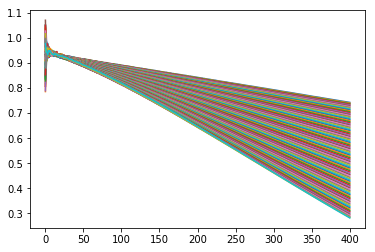

In [121]:
plt.plot(r_cen,inv_phi);

#### Now expand into multipoles

In [95]:
l_max = 8
from scipy.special import legendre
inv_Phi_multipoles = np.zeros([l_max//2+1,len(inv_phi)])
for i in range(len(RR_true)):
    for l_i,ell in enumerate(np.arange(0,l_max+2,2)):
        inv_Phi_multipoles[l_i,i]=(2.*ell+1.)*delta_mu*np.sum(legendre(ell)(mu_cen)*inv_phi[i,:])

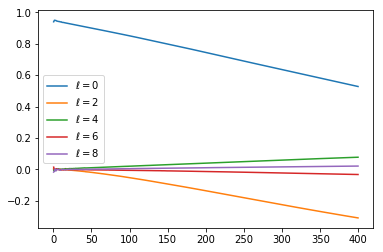

In [96]:
for i in range(5):
    plt.plot(r_cen,inv_Phi_multipoles[i],label=r'$\ell =%d$'%(i*2))
plt.legend();

In [79]:
np.savez('/mnt/store1/oliverphilcox/PowerSpectra/InvPhiMultipoles.npz',r=r_cen,l_max=l_max,multipoles=inv_Phi_multipoles)

In [179]:
def inv_phi_ell_model(r,*par):
    return par[0]+par[1]*r+par[2]*r**2.#+par[3]*r**3.#+par[4]*r**4.
from scipy.optimize import curve_fit
max_l = 4
all_ell = np.arange(0,max_l+2,2)
coeff = np.asarray([curve_fit(inv_phi_ell_model,r_cen[1:],inv_Phi_multipoles[ell//2][1:],
                              p0=[0 for _ in range(3)])[0] for ell in all_ell])

In [180]:
def recon_model(r,mu):
    out=0.
    for ell in all_ell:
        pars = coeff[ell//2]
        out+=inv_phi_ell_model(r,*pars)*legendre(ell)(mu)
    return out

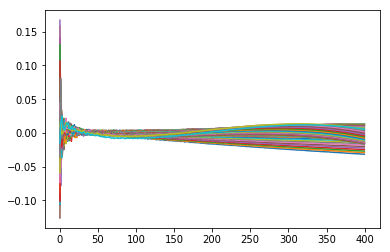

In [181]:
for i,mu in enumerate(mu_cen):
    plt.plot(r_cen,recon_model(r_cen,mu)-inv_phi[:,i])

In [184]:
np.savetxt("/mnt/store1/oliverphilcox/PowerSpectra/InvPhiCoeff_DR12.txt",coeff,delimiter="\t")

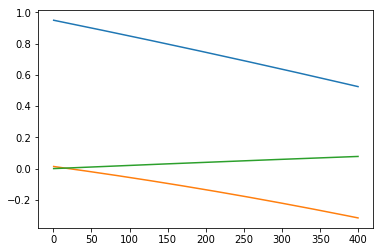

In [182]:
for ell in all_ell:
    pars = coeff[ell//2]
    plt.plot(r_cen,inv_phi_ell_model(r_cen,*pars))